# Import libraries

In [24]:
%reload_ext autoreload
%autoreload 2
import json
import re
from datetime import datetime
from pathlib import Path

import matplotlib as mpl
import numpy as np
import pandas as pd
import pycountry
from unidecode import unidecode

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
mpl.rcParams["figure.dpi"] = 300

# Import raw data

In [25]:
# Set up directories
BASE_DIR: Path = Path().resolve().parent
DATA_DIR: Path = BASE_DIR / "data"
RAW_DATA_DIR: Path = DATA_DIR / "raw"


# Load data
file_path_in: Path = RAW_DATA_DIR / "25072024_reviews.csv"
if not file_path_in.exists():
    raise FileNotFoundError(f"File {file_path_in} not found.")

df_in: pd.DataFrame = pd.read_csv(file_path_in)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   rating                             7890 non-null   object 
 1   roaster                            7890 non-null   object 
 2   title                              7890 non-null   object 
 3   blind_assessment                   7889 non-null   object 
 4   notes                              7888 non-null   object 
 5   bottom_line                        3812 non-null   object 
 6   roaster location                   7887 non-null   object 
 7   coffee origin                      7386 non-null   object 
 8   roast level                        7488 non-null   object 
 9   agtron                             7890 non-null   object 
 10  est. price                         5852 non-null   object 
 11  review date                        7890 non-null   objec

# Initial Cleanup

In [26]:
# Cleanup column names
df_in.columns = (
    df_in.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "")
)

df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            7890 non-null   object 
 1   roaster                           7890 non-null   object 
 2   title                             7890 non-null   object 
 3   blind_assessment                  7889 non-null   object 
 4   notes                             7888 non-null   object 
 5   bottom_line                       3812 non-null   object 
 6   roaster_location                  7887 non-null   object 
 7   coffee_origin                     7386 non-null   object 
 8   roast_level                       7488 non-null   object 
 9   agtron                            7890 non-null   object 
 10  est_price                         5852 non-null   object 
 11  review_date                       7890 non-null   object 
 12  aroma 

In [27]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Initial data cleaning pipeline.
    Steps performed:
    - Converts non-standard missing values to NaN.
    - Strips whitespace from string columns.
    - Parses and standardizes date and numeric fields.
    - Splits the "agtron" column into "agtron_external" and "agtron_ground".
    - Derives new flags (e.g., is_espresso).
    - Drops unnecessary or redundant columns.

    Args:
        df: The raw input DataFrame.

    Returns:
        Tweaked DataFrame.

    """
    strings_to_nan = ["", "NR", "N/A", "na", "NA", "Not Available"]
    return (
        df.map(lambda x: x.strip() if isinstance(x, str) else x)
        .assign(
            review_date=lambda df_: pd.to_datetime(df_["review_date"], format="%B %Y"),
            # Combine acidity and acidity/structure into one column
            acidity=lambda df_: pd.to_numeric(
                df_["acidity"].fillna(df_["acidity/structure"]), errors="coerce"
            ),
            # Split the agtron column into external and ground
            agtron_external=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[0].str.strip(),
                errors="coerce",
            ).where(lambda x: x <= 100),
            agtron_ground=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[1].str.strip(),
                errors="coerce",
            ).where(lambda x: x <= 100),
            # Flag espresso roasts
            is_espresso=lambda df_: (
                df_["title"].str.contains("espresso", case=False, na=False)
                | df_["with_milk"].notnull()
            ),
            # Set to nan price column that doesn't contain a number
            est_price=lambda df_: (
                df_["est_price"].where(
                    df_["est_price"].str.contains(r"\d", na=False), np.nan
                )
            ),
        )
        .replace(strings_to_nan, np.nan)
        .drop(
            columns=["acidity/structure", "agtron", "refresh(enable_javascript_first)"]
        )
        .astype(
            {
                k: "float"
                for k in [
                    "acidity",
                    "rating",
                    "aroma",
                    "body",
                    "flavor",
                    "aftertaste",
                ]
            }
        )
    )


df: pd.DataFrame = tweak_df(df_in)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rating            7886 non-null   float64       
 1   roaster           7890 non-null   object        
 2   title             7890 non-null   object        
 3   blind_assessment  7889 non-null   object        
 4   notes             7888 non-null   object        
 5   bottom_line       3812 non-null   object        
 6   roaster_location  7887 non-null   object        
 7   coffee_origin     7386 non-null   object        
 8   roast_level       7488 non-null   object        
 9   est_price         5843 non-null   object        
 10  review_date       7890 non-null   datetime64[ns]
 11  aroma             7829 non-null   float64       
 12  acidity           6611 non-null   float64       
 13  body              7878 non-null   float64       
 14  flavor            7873 n

# Price and Quantity Cleaning

## Cleaning quantities

In [28]:
# Defining list of quantity terms to drop from the dataset
drop_terms: list[str] = [
    r"\bcan(?:s)?\b",
    r"\bbox(?:es|ed)?\b",
    r"\bcapsule(?:s)?\b",
    r"\bK-\b",
    r"\bflask(?:s)?\b",
    r"\bcup(?:s)?\b",
    r"\bbag(?:s)?\b",
    r"\bconcentrate(?:s)?\b",
    r"\bdisc(?:s)?\b",
    r"\bbottle(?:s)?\b",
    r"\bpod(?:s)?\b",
    r"\bpouch(?:es)?\b",
    r"\bpacket(?:s)?\b",
    r"\btin(?:s)?\b",
    r"\binstant\b",
    r"\bsachet(?:s)?\b",
    r"\bvue\b",
    r"\bsingle-serve(?:s)?\b",
    r"\bfluid(?:s)?\b",
]
# Regex drop term string
drop_terms_string: str = r"|".join(drop_terms)

# Regex patterns
remove_parentheses_pattern: re.Pattern[str] = re.compile(r"\(.*?\)")
remove_after_left_parenthesis_pattern: re.Pattern[str] = re.compile(r"\(.*$")
remove_notes_pattern: re.Pattern[str] = re.compile(r";.*")
remove_online_pattern: re.Pattern[str] = re.compile(r"online")
standardize_units_patterns: list[tuple[re.Pattern[str], str]] = [
    (re.compile(r"\bgrams"), "grams"),
    (re.compile(r"\bgram\b"), "grams"),
    (re.compile(r".g$"), " grams"),
    (re.compile(r"pound$"), "1 pounds"),
    (re.compile(r"oz|onces|ouncues|ounce$|ounces\*"), "ounces"),
    (re.compile(r"kilogram"), "kilograms"),
    (re.compile(r"kg"), "kilograms"),
    (re.compile(r"capsulte"), "capsule"),
]
number_pattern: re.Pattern[str] = re.compile(r"(\d+(?:\.\d+)?)")
currency_pattern: re.Pattern[str] = re.compile(r"(\d+\.\d+|\d+)")

# Final quantity units
allowed_quantity_units: list[str] = ["ounces", "pounds", "grams", "kilograms"]

In [35]:
def prep_quantity_column(column: pd.Series) -> pd.Series:
    """
    Cleans and standardizes the 'quantity' column in the dataset.
    """
    return (
        column.str.lower()
        .str.strip()
        # Remove parentheses and notes
        .str.replace(remove_parentheses_pattern, "", regex=True)
        .str.replace(remove_after_left_parenthesis_pattern, "", regex=True)
        .str.replace(remove_notes_pattern, "", regex=True)
        # Clean and standardize quantity units
        .pipe(
            lambda s: s.replace(
                {pat: repl for pat, repl in standardize_units_patterns},
                regex=True,
            )
        )
        # Remove "online" from any quantity
        .str.replace(remove_online_pattern, "", regex=True)
        .str.strip()
    )


def filter_unwanted_terms(column: pd.Series, terms: str) -> pd.Series:
    """
    Filters out rows that contain unwanted terms in a given column.
    """
    return ~column.str.lower().str.contains(terms.lower(), case=False, na=False)


def prep_price_column(column: pd.Series) -> pd.Series:
    """
    Cleans the 'price' column in the dataset by replacing invalid characters.
    """
    return column.str.replace("..", ".")


def extract_quantity_value(column: pd.Series) -> pd.Series:
    """
    Extracts numerical values from the 'quantity' column.
    """
    return column.str.extract(number_pattern).astype(float)


def extract_quantity_unit(column: pd.Series) -> pd.Series:
    """
    Extracts and standardizes the unit of measurement from the 'quantity' column.
    """
    return (
        column.str.replace(number_pattern, "", regex=True)
        .replace(r"\.", "", regex=True)
        .str.strip()
        .mask(lambda s: s == "g", "grams")
        .mask(lambda s: s == "kilo", "kilograms")
        .str.strip()
    )


def extract_price_value(column: pd.Series) -> pd.Series:
    """
    Extracts numberical values from the 'price' column.
    """
    return column.str.extract(currency_pattern).astype(float)


def extract_price_currency(column: pd.Series) -> pd.Series:
    """
    Removes numerical part of price column to leave only the currency symbol/code.
    """
    return (
        column.str.replace(",", "")
        .str.replace(currency_pattern, "", regex=True)
        .str.strip()
    )


def create_price_quantity_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the 'est_price' column to extract and clean price and quantity
    information.

    Steps performed:
    - Splits the 'est_price' column into 'price' and 'quantity' columns.
    - Cleans and standardizes the 'price' and 'quantity' columns.
    - Extracts numerical values and units from the 'quantity' column.
    - Extracts numerical values and currency symbols from the 'price' column.

    Args:
        df: The input DataFrame containing the 'est_price' column.

    Returns:
        A DataFrame with additional columns:
        - 'price': Cleaned price strings.
        - 'quantity': Cleaned quantity strings.
        - 'quantity_value': Numerical values extracted from 'quantity'.
        - 'quantity_unit': Standardized unit strings from 'quantity'.
        - 'price_value': Numerical values extracted from 'price'.
        - 'price_currency': Extracted currency symbols or labels.
    """
    return (
        df.assign(
            # Split est_price into price and quantity, removing commas
            **df["est_price"]
            .str.replace(r"\bfor\b", "/", regex=True)
            .str.split("/", n=1, expand=True)
            .replace(",", "", regex=True)
            .rename(columns={0: "price", 1: "quantity"})
        )
        # Filter out rows with unwanted terms in the quantity column
        .loc[lambda x: filter_unwanted_terms(x["quantity"], drop_terms_string)]
        .assign(
            quantity=lambda x: prep_quantity_column(x["quantity"]),
            price=lambda x: prep_price_column(x["price"]),
        )
        .assign(
            quantity_unit=lambda x: extract_quantity_unit(x["quantity"]),
            quantity_value=lambda x: extract_quantity_value(x["quantity"]),
            price_value=lambda x: extract_price_value(x["price"]),
            price_currency=lambda x: extract_price_currency(x["price"]),
        )
    )


df = df_in.pipe(tweak_df).pipe(create_price_quantity_columns)
df[
    [
        "est_price",
        "price",
        "quantity",
        "quantity_value",
        "quantity_unit",
        "price_value",
        "price_currency",
    ]
].dropna().sample(10)

,est_price,price,quantity,quantity_value,quantity_unit,price_value,price_currency
2364,$19.00/12 ounces,$19.00,12 ounces,12.0,ounces,19.00,$
6228,$10.00/250 grams,$10.00,250 grams,250.0,grams,10.00,$
952,NT $1200/16 ounces,NT $1200,16 ounces,16.0,ounces,1200.00,NT $
5926,$13.95/12 ounces,$13.95,12 ounces,12.0,ounces,13.95,$
1624,NT $580/227 grams,NT $580,227 grams,227.0,grams,580.00,NT $
2799,$5.00/12 ounces,$5.00,12 ounces,12.0,ounces,5.00,$
4619,NT $450/8 ounces,NT $450,8 ounces,8.0,ounces,450.00,NT $
7545,$17.00/12 ounces,$17.00,12 ounces,12.0,ounces,17.00,$
7768,$12.75/12 ounces,$12.75,12 ounces,12.0,ounces,12.75,$
6626,$49.00/8 ounces,$49.00,8 ounces,8.0,ounces,49.00,$


In [36]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return dataframe with a new column containing quantity in lbs

    Args:
        df: DataFrame containing a "quantity_value" column.

    Returns:
        DataFrame with "quantity_in_lbs" column.
    """
    convert_to_lbs_map: dict[str, float] = {
        "ounces": 1 / 16,
        "pounds": 1,
        "kilograms": 2.20462,
        "grams": 0.00220462,
    }

    df["quantity_in_lbs"] = np.round(
        df["quantity_value"] * df["quantity_unit"].map(convert_to_lbs_map), 3
    )
    return df


df = df_in.pipe(tweak_df).pipe(create_price_quantity_columns).pipe(convert_to_lbs)

## Cleaning Prices and Currencies
Here we normalize the currency column to contain a standard set of ISO 4217 currency codes. This will help us with fetching exchange rates from an API later on.

In [38]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize currencies to ISO 4217 codes."""
    currency_map = {
        "PRICE: $": "USD",
        "#": "GBP",
        "¥": "JPY",
        "£": "GBP",
        "€": "EUR",
        "POUND": "GBP",
        "PESOS": "COP",  # Only pesos are from colombian roasts so COP
        "RMB": "CNY",
        "EUROS": "EUR",
        "RM": "MYR",
    }
    price_currency = (
        df.price_currency.str.upper()
        .str.replace(r"^\$$", "USD", regex=True)
        .replace(currency_map, regex=False)
        .replace(r"\$", "", regex=True)
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == " ", "USD")
        .mask(lambda s: s == "E", "EUR")
        .mask(lambda s: s == "NTD", "TWD")
        .mask(lambda s: s == "NT", "TWD")
        .mask(lambda s: s == "", "USD")
        .mask(lambda s: s == "HK", "HKD")
        .str.strip()
    )
    return df.assign(price_currency=price_currency)


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(convert_to_lbs)
    .pipe(clean_currency)
)

# Check that currencies make sense from original est_price column
df.loc[
    :, ["est_price", "price_currency", "price_value", "title", "coffee_origin"]
].groupby(
    "price_currency",
).sample(3, replace=True)


price_currency_counts = df.price_currency.value_counts()

df.price_currency.value_counts()

price_currency
USD    4277
TWD    1070
CAD     125
HKD      46
RMB      22
THB      21
KRW      20
JPY      14
GBP      11
AUD      10
EUR       6
AED       5
CNY       5
MYR       3
IDR       3
GTQ       1
COP       1
LAK       1
Name: count, dtype: int64

### Inflation adjustment and converting to USD
Using historical exchange rates we will convert all prices to USD. We then adjust prices from historical USD to 2024 USD using the BLS [consumer price index](https://data.bls.gov/PDQWeb/cu).


In [10]:
with open(DATA_DIR / "external/openex_exchange_rates.json") as f:
    currency_codes: dict[str, dict[str, float]] = dict(json.load(f))


def row_convert_currency(row: pd.Series) -> float | np.float64:
    """
    Convert a price value in a Series row to a base currency.

    Args:
        row (pd.Series): A Series with the following fields:
            - 'review_date' (datetime or str): The date of the review.
            - 'price_currency' (str): The currency code (e.g., "USD", "EUR").
            - 'price_value' (float): The price value to be converted.

    Returns:
        float | np.float64: The converted price, rounded to two decimals,
                            or NaN if the conversion fails.
    """
    try:
        date: str = str(row.review_date.strftime("%Y-%m-%d"))
        currency: str = str(row.price_currency)
        value: float | np.float64 = np.round(
            row.price_value / currency_codes[date][currency], 2
        )
    except KeyError:
        value = np.nan
    return value


def convert_currency(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd"] = df.apply(row_convert_currency, axis=1)
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)
)


df.groupby("price_currency")[
    [
        "price_usd",
        "price_value",
        "price_currency",
    ]
].sample(1)

,price_usd,price_value,price_currency
415,25.86,95.0,AED
3820,12.26,16.0,AUD
3738,54.14,55.0,CAD
5077,20.50,150.0,CNY
4945,0.13,500.0,COP
3987,11.08,9.9,EUR
6452,30.37,23.9,GBP
1575,12.53,100.0,GTQ
3842,68.13,530.0,HKD
6363,8.89,120000.0,IDR


In [11]:
df.head()

,rating,roaster,title,blind_assessment,notes,bottom_line,roaster_location,coffee_origin,roast_level,est_price,review_date,aroma,acidity,body,flavor,aftertaste,url,with_milk,agtron_external,agtron_ground,is_espresso,price,quantity,quantity_unit,quantity_value,price_value,price_currency,price_usd
0,92.0,Red Rooster Coffee Roaster,Ethiopia Sidama Shoye,"Rich, intricate and layered. Lemon zest, roasted cacao nib, violet, mulberry, frankincense in ar...",Produced by family-owned farms that are part of the Shoye Cooperative. This lot was processed by...,"An elegant washed Sidamo cup, both deeply sweet and delicately tart.","Floyd, Virginia","Sidamo (also Sidama) growing region, southern Ethiopia",Medium-Light,$14.49/12 ounces,2016-11-01,9.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-sidama-shoye/,NaN,56.0,80.0,False,$14.49,12 ounces,ounces,12.0,14.49,USD,14.49
1,92.0,El Gran Cafe,Finca Santa Elisa Geisha,"Gently sweet-tart, crisply herbaceous. Baking chocolate, green grape, lemon verbena, fresh-cut o...","Produced by Finca Santa Elisa entirely of the Geisha variety of Arabica, and processed by the tr...","A confident, pretty washed-process Guatemala Geisha enlivened by crisp chocolate and sweet herb ...","Antigua, Guatemala","Acatenango growing region, Guatemala",Medium-Light,$30.00/12 ounces,2023-08-01,8.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/finca-santa-elisa-geisha/,NaN,62.0,78.0,False,$30.00,12 ounces,ounces,12.0,30.00,USD,30.00
2,93.0,Tipico Coffee,Costa Rica Sin Limites Gesha,"Floral-toned, tropical-leaning. Magnolia, guava, green banana, amber, cocoa nib in aroma and cup...","Produced by Jamie Cardenas of Finca Sin Limites, entirely of the Gesha variety of Arabica, and p...","A delicate honey-processed Costa Rica Gesha that evokes the tropics with its fruity profile, and...","Buffalo, New York","West Valley, Costa Rica",Light,$33.00/12 ounces,2024-06-01,9.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/costa-rica-sin-limites-gesha/,NaN,60.0,82.0,False,$33.00,12 ounces,ounces,12.0,33.00,USD,33.00
3,91.0,Roast House,Ride the Edge,"Crisply floral, delicately lively. Complex flowers – lavender, lilac – roasted cacoa nib, tanger...","The coffees in this blend are certified organically grown and Fair Trade, meaning they were purc...",NaN,"Spokane, Washington","Southern Ethiopia; Mexico; northern Sumatra, Indonesia.",Medium,$14.00/16 ounces,2015-07-01,8.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ride-the-edge/,NaN,53.0,67.0,False,$14.00,16 ounces,ounces,16.0,14.00,USD,14.00
4,92.0,Level Ground Trading,Direct Fair Trade Espresso,"Evaluated as espresso. Intrigungly complex, balanced. Dark chocolate, molasses, cedar, narcissus...",Coffees in this blend are all fully wet-processed or “washed” and certified organically grown in...,A solid espresso blend equally pleasing as a straight shot and in milk.,"Victoria, British Columbia, Canada",Africa; South America,Medium-Light,CAD $17.00/16 ounces,2017-11-01,9.0,NaN,8.0,8.0,8.0,https://www.coffeereview.com/review/direct-fair-trade-espresso-2/,9,51.0,73.0,True,CAD $17.00,16 ounces,ounces,16.0,17.00,CAD,13.21


In [39]:
def load_cpi_dataframe(file_path: Path) -> pd.DataFrame:
    """Loads and transforms Consumer Price Index data."""
    try:
        cpi: pd.DataFrame = pd.read_csv(file_path)
    except FileNotFoundError as exc:
        raise FileNotFoundError(
            "CPI file is not found in the specified directory."
        ) from exc

    # Cleanup CPI data column names. Columns will be year, the months, and "half"
    cpi.columns = cpi.columns.str.strip().str.lower().str.replace(" ", "_")

    return (
        cpi.drop(columns=["half1", "half2"])
        .melt(id_vars="year", var_name="month", value_name="cpi")
        .assign(
            month=lambda df_: df_["month"].apply(
                lambda x: datetime.strptime(x, "%b").month
            ),
            date=lambda df_: pd.to_datetime(df_[["year", "month"]].assign(day=1)),
        )
        .drop(columns=["year", "month"])
    )


def adjust_row(row: pd.Series, cpi_baseline: float) -> float:
    # CPI is NaN for the current month, return the original price_usd
    if pd.isnull(row["cpi"]):
        return row["price_usd"]
    else:
        return np.round(row["price_usd"] * (cpi_baseline / row["cpi"]), 2)


def create_cpi_adjusted_price(
    df: pd.DataFrame, file_path: Path, date: str = "2024-06-01"
) -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi: pd.DataFrame = load_cpi_dataframe(file_path)
    cpi_baseline: float = cpi.loc[cpi["date"] == date, "cpi"].values[0]

    return df.merge(cpi, how="left", left_on="review_date", right_on="date").assign(
        price_usd_adj=lambda df_: df_.apply(
            adjust_row, cpi_baseline=cpi_baseline, axis=1
        )
    )


cpi_path: Path = DATA_DIR / "external" / "consumer_price_index.csv"

df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(convert_to_lbs)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
)

df.groupby("price_currency")[
    [
        "price_value",
        "price_currency",
        "price_usd",
        "review_date",
        "price_usd_adj",
    ]
].sample(1)

,price_value,price_currency,price_usd,review_date,price_usd_adj
1430,103.95,AED,28.30,2019-09-01,34.63
865,15.00,AUD,11.26,2016-07-01,14.70
4853,11.49,CAD,11.82,2011-06-01,16.45
4755,399.00,CNY,55.01,2023-07-01,56.54
4831,500.00,COP,0.13,2021-05-01,0.15
7100,11.90,EUR,15.72,2013-01-01,21.45
2489,14.50,GBP,17.66,2023-11-01,18.07
1540,100.00,GTQ,12.53,2013-09-01,16.81
5048,168.00,HKD,21.66,2012-09-01,29.41
4886,120000.00,IDR,8.52,2019-12-01,10.42


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

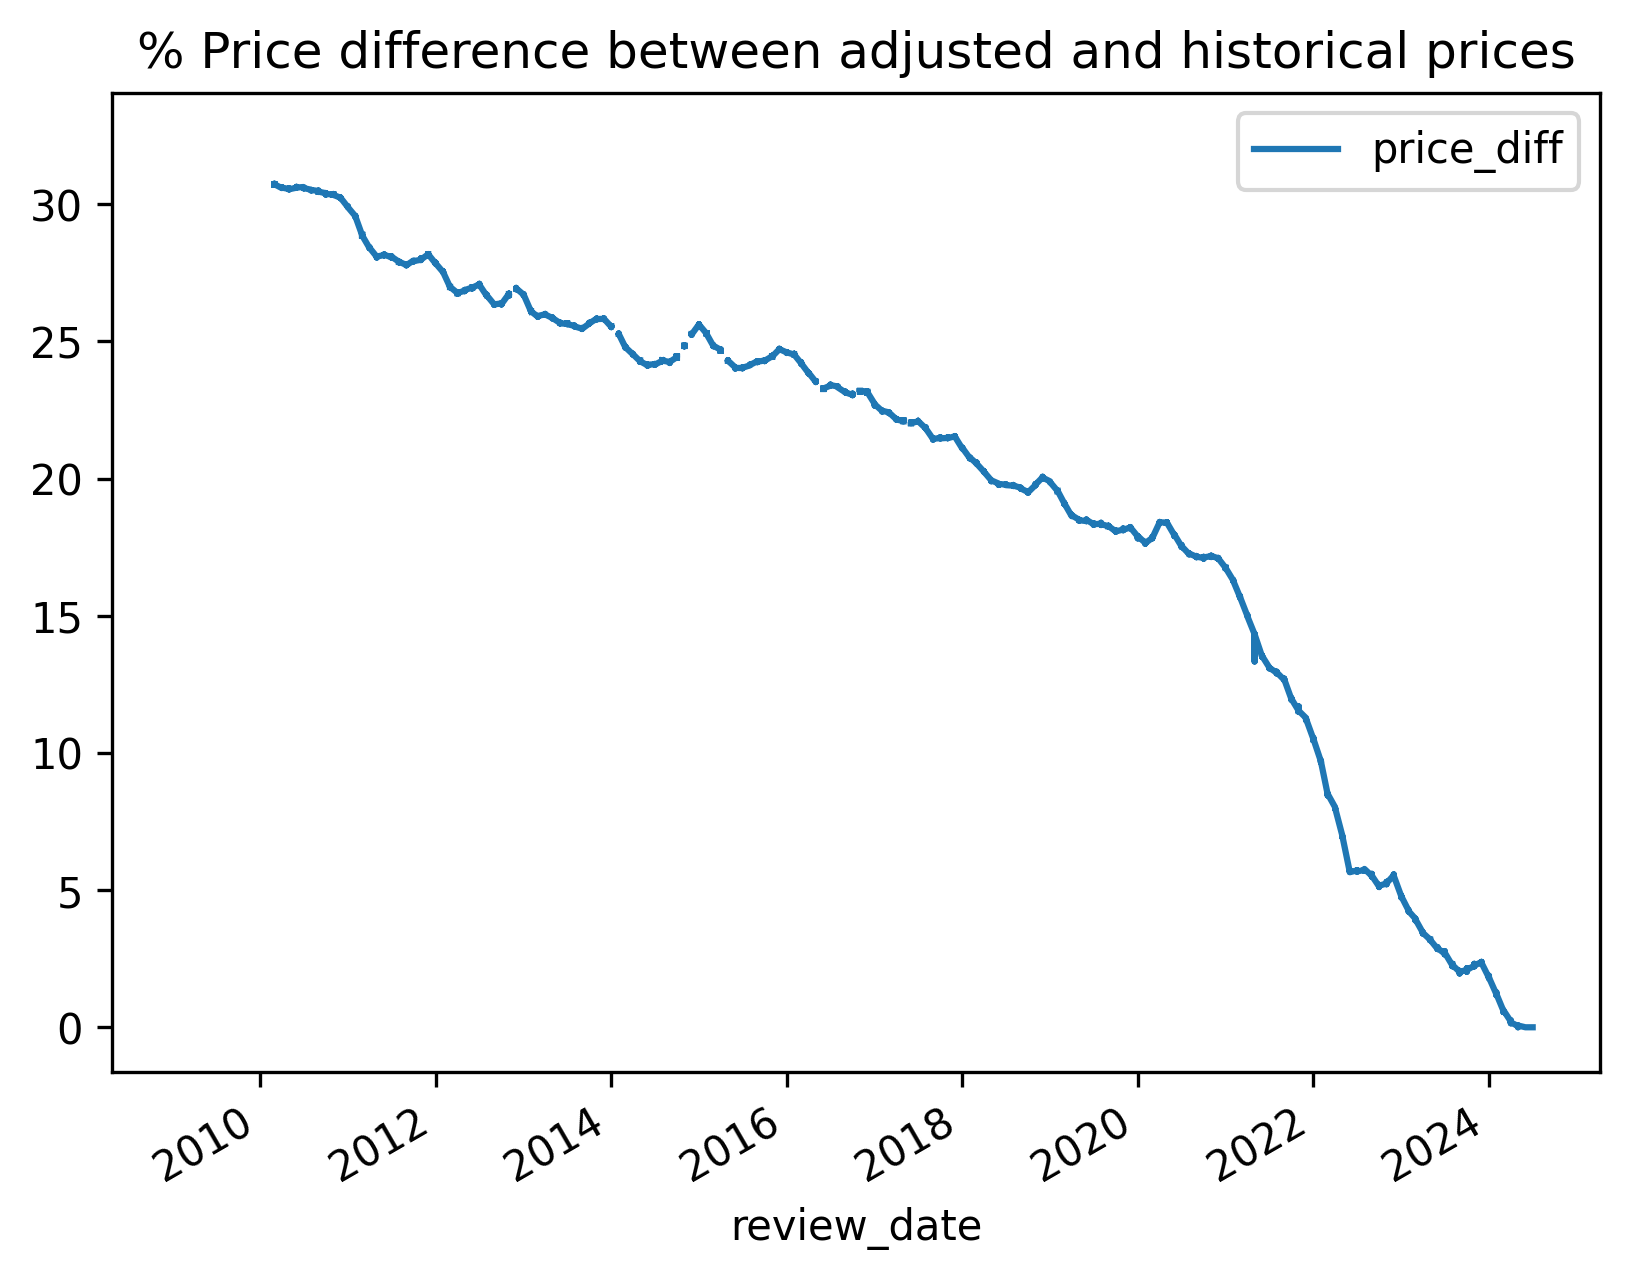

In [13]:
# Plot the price difference between the adjusted and historical prices over time

(
    df.assign(
        price_diff=lambda df_: (df_["price_usd_adj"] - df_["price_usd"])
        / df_["price_usd_adj"]
        * 100
    ).sort_values("review_date")
).plot(
    x="review_date",
    y="price_diff",
    title="% Price difference between adjusted and historical prices",
)

### Create a column for $USD/lb using adjusted price 

In [14]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd_adj_per_lb"] = np.round(
        df["price_usd_adj"] / df["quantity_in_lbs"], 2
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)  # Convert to USD with historical exchange rates
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)  # Adjust for inflation
    .pipe(convert_to_lbs)  # Convert quantities to pounds
    .pipe(price_per_lbs)  # Calculate adjusted USD price per pound
)

df.head()

,rating,roaster,title,blind_assessment,notes,bottom_line,roaster_location,coffee_origin,roast_level,est_price,review_date,aroma,acidity,body,flavor,aftertaste,url,with_milk,agtron_external,agtron_ground,is_espresso,price,quantity,quantity_unit,quantity_value,price_value,price_currency,price_usd,cpi,date,price_usd_adj,quantity_in_lbs,price_usd_adj_per_lb
0,92.0,Red Rooster Coffee Roaster,Ethiopia Sidama Shoye,"Rich, intricate and layered. Lemon zest, roasted cacao nib, violet, mulberry, frankincense in ar...",Produced by family-owned farms that are part of the Shoye Cooperative. This lot was processed by...,"An elegant washed Sidamo cup, both deeply sweet and delicately tart.","Floyd, Virginia","Sidamo (also Sidama) growing region, southern Ethiopia",Medium-Light,$14.49/12 ounces,2016-11-01,9.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-sidama-shoye/,NaN,56.0,80.0,False,$14.49,12 ounces,ounces,12.0,14.49,USD,14.49,241.353,2016-11-01,18.86,0.75,25.15
1,92.0,El Gran Cafe,Finca Santa Elisa Geisha,"Gently sweet-tart, crisply herbaceous. Baking chocolate, green grape, lemon verbena, fresh-cut o...","Produced by Finca Santa Elisa entirely of the Geisha variety of Arabica, and processed by the tr...","A confident, pretty washed-process Guatemala Geisha enlivened by crisp chocolate and sweet herb ...","Antigua, Guatemala","Acatenango growing region, Guatemala",Medium-Light,$30.00/12 ounces,2023-08-01,8.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/finca-santa-elisa-geisha/,NaN,62.0,78.0,False,$30.00,12 ounces,ounces,12.0,30.00,USD,30.00,307.026,2023-08-01,30.70,0.75,40.93
2,93.0,Tipico Coffee,Costa Rica Sin Limites Gesha,"Floral-toned, tropical-leaning. Magnolia, guava, green banana, amber, cocoa nib in aroma and cup...","Produced by Jamie Cardenas of Finca Sin Limites, entirely of the Gesha variety of Arabica, and p...","A delicate honey-processed Costa Rica Gesha that evokes the tropics with its fruity profile, and...","Buffalo, New York","West Valley, Costa Rica",Light,$33.00/12 ounces,2024-06-01,9.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/costa-rica-sin-limites-gesha/,NaN,60.0,82.0,False,$33.00,12 ounces,ounces,12.0,33.00,USD,33.00,314.175,2024-06-01,33.00,0.75,44.00
3,91.0,Roast House,Ride the Edge,"Crisply floral, delicately lively. Complex flowers – lavender, lilac – roasted cacoa nib, tanger...","The coffees in this blend are certified organically grown and Fair Trade, meaning they were purc...",NaN,"Spokane, Washington","Southern Ethiopia; Mexico; northern Sumatra, Indonesia.",Medium,$14.00/16 ounces,2015-07-01,8.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ride-the-edge/,NaN,53.0,67.0,False,$14.00,16 ounces,ounces,16.0,14.00,USD,14.00,238.654,2015-07-01,18.43,1.00,18.43
4,92.0,Level Ground Trading,Direct Fair Trade Espresso,"Evaluated as espresso. Intrigungly complex, balanced. Dark chocolate, molasses, cedar, narcissus...",Coffees in this blend are all fully wet-processed or “washed” and certified organically grown in...,A solid espresso blend equally pleasing as a straight shot and in milk.,"Victoria, British Columbia, Canada",Africa; South America,Medium-Light,CAD $17.00/16 ounces,2017-11-01,9.0,NaN,8.0,8.0,8.0,https://www.coffeereview.com/review/direct-fair-trade-espresso-2/,9,51.0,73.0,True,CAD $17.00,16 ounces,ounces,16.0,17.00,CAD,13.21,246.669,2017-11-01,16.83,1.00,16.83


# Coffee Origin Cleaning

In [15]:
def get_standard_countries(
    add: list[str] | None = None, remove: list[str] | None = None
) -> set:
    """Return a modified list of country names from pycountry"""

    countries = set(unidecode(c.name.lower()) for c in pycountry.countries)

    if remove:
        for r in remove:
            try:
                countries.remove(r)
            except ValueError:
                continue

    for c in list(countries):
        if "(" in c:
            countries.remove(c)
            continue
        c_new: str = c.split(",")[0]
        countries.remove(c)
        countries.add(c_new)

    if add:
        for a in add:
            countries.add(a)
    return countries


standardized_countries: set[str] = get_standard_countries()

print(pd.Series(list(standardized_countries)).sort_values())

233          afghanistan
73         aland islands
54               albania
97               algeria
220       american samoa
             ...        
108    wallis and futuna
64        western sahara
36                 yemen
35                zambia
203             zimbabwe
Length: 241, dtype: object


In [16]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)


display(df.coffee_origin.sample(100))

# ";" means multiple
# "and" means multiple
# "undisclosed" means multiple
# "various" means multiple
# lowercase, strip whitespace
# remove punctuation, apostrophes
# hawaii, sanna, gedeo, kilimanjaro cleanup

1957                                                     Nyamyumba region, Rwanda.
7085                                                  Dominican Republic; Honduras
5544                                                                           NaN
5891                            Yirgacheffe growing region, south-central Ethiopia
1948                                                                     Guatemala
4328                                         Kirinyaga County, south-central Kenya
4455                                                Gedeo Zone, southern Ethiopia.
2002                     Lintong growing region, North Sumatra Province, Indonesia
2116                                                    Panama; Honduras; Ethiopia
4964                                                    Huila Department, Colombia
3438                                          Piendamo, Cauca Department, Colombia
7319                                                                   El Salvador
4153

In [17]:
def retrieve_countries(element: str, countries: set) -> str:
    countries_found: set = set()
    if pd.isna(element) or element == "":
        return ""
    for c in countries:
        if c in element:
            countries_found.add(c)
    if len(countries_found) == 0:
        return element
    # alphabetically sort the countries found
    countries_found = sorted(countries_found)
    return ";".join(countries_found)


def clean_origin(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(coffee_origin=df.coffee_origin.str.lower())
    df["origin_country"] = df.coffee_origin.apply(
        retrieve_countries, countries=standardized_countries
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
    .pipe(convert_to_lbs)
    .pipe(price_per_lbs)
    .pipe(clean_origin)
)

In [18]:
df.origin_country.value_counts()

origin_country
ethiopia                                                                                            1330
colombia                                                                                             680
kenya                                                                                                613
                                                                                                     504
guatemala                                                                                            448
indonesia                                                                                            370
not disclosed.                                                                                       334
panama                                                                                               307
costa rica                                                                                           306
el salvador                             

# Export processed data

In [19]:
file_out: Path = Path(f"{file_path_in.stem}_intermediate{file_path_in.suffix}")
file_path_out = DATA_DIR / "intermediate" / file_out
if not file_path_out.exists():
    raise FileNotFoundError(f"File {file_path_out} not found.")

df.to_csv(DATA_DIR / "intermediate" / file_path_out, index=False)